## Carbon Footprint Assessment:
Develop a metric for evaluating building carbon footprints, accounting for energy and water consumption, size, and other factors.

In [58]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json
from sklearn.metrics import silhouette_score

In [59]:
# Load the schema from the JSON file
with open('./data/schema_cleaned.json') as schema_file:
    schema = json.load(schema_file)

# Convert schema to the format required by pandas
# Note: In this case, we're assuming all the dtypes are compatible with pandas dtypes.
# If there are any discrepancies, you may need to manually adjust the dtypes.
pandas_schema = {key: value for key, value in schema.items()}
feature_list = [key for key, value in schema.items()]

## Data Preparation
Since not all our data is numerical, we'll need to do some one-hot encoding.
Given all the categorical columns, we're going to use pandas library for one-hot encoding.

In [60]:
# Now read the cleaned CSV file using the schema
df_cleaned = pd.read_csv('./data/data_cleaned.csv', dtype=pandas_schema)

# Select the categorical columns that need one-hot encoding
categorical_columns = [key for key, value in schema.items() if value == 'object']

# Perform one-hot encoding on the selected columns, and will be used for K-Means
data_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns)  # Perform one-hot encoding

## Feature Selection & Scaling
Choosing the relevant features for clustering the different types of buildings

In [61]:
# Scale our data for a mean of 0
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded)

In [62]:
# Perform dimensionality reduction using PCA
num_components = 15
pca = PCA(n_components=num_components)  # Adjust the number of components as needed
reduced_features = pca.fit_transform(data_encoded)

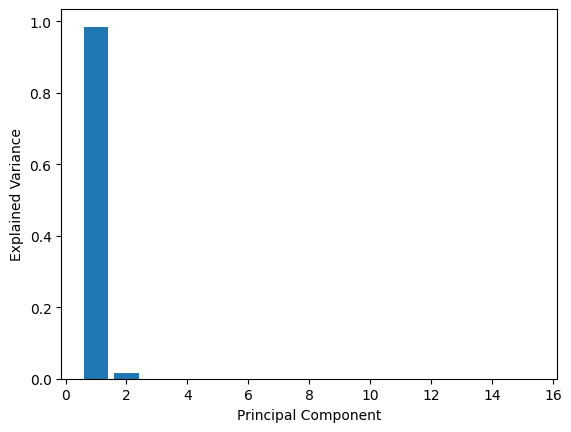

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [64]:
# Fit the PCA model to your data
pca.fit(data_encoded)

# Get the transformed data (principal components)
components = pca.transform(data_encoded)

# Calculate the explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance to decide on the number of components to keep
plt.bar(range(1, num_components + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [73]:
# Now, you can examine which original features contribute most to the first few components
component_number = 1  # Choose the component number you want to investigate
feature_contributions = abs(pca.components_[component_number - 1])
sorted_features = sorted(zip(data_encoded.columns, feature_contributions), key=lambda x: -x[1])

# Print the most important features for the chosen component
print(f"Most important features for Principal Component {component_number}:")
print(feature_contributions)
contributions = {}
count = 0
for feature, contribution in sorted_features:
    contributions[feature] = contribution
    print(f"{feature}: {contribution:.2f}")
    count += 1
    if count > 500:
        break

Most important features for Principal Component 1:
[9.99981294e-01 2.63145052e-03 6.20530658e-07 ... 1.02216322e-09
 2.62009042e-10 6.60247376e-10]
property_id: 1.00
property_gfa_calculated: 0.00
property_gfa_calculated_1: 0.00
property_gfa_self_reported: 0.00
multifamily_housing_gross: 0.00
largest_property_use_type_1: 0.00
national_median_total_ghg: 0.00
net_emissions_metric_tons: 0.00
multifamily_housing_number: 0.00
indirect_ghg_emissions_metric: 0.00
multifamily_housing_total: 0.00
multifamily_housing_number_4: 0.00
multifamily_housing_percent: 0.00
multifamily_housing_number_6: 0.00
year_built: 0.00
national_median_site_eui: 0.00
occupancy: 0.00
number_of_active_energy_meters: 0.00
number_of_active_energy_meters_1: 0.00
estimated_values_water_No: 0.00
estimated_values_water_Unable to Check (not enough data): 0.00
alert_water_meter_has_less_Unable to Check (not enough data): 0.00
multifamily_housing_percent_1: 0.00
national_median_source_eui: 0.00
alert_water_meter_has_less_Ok: 0.

## K-Means Clustering
After dimensionality reduction, we proceed with K-Means clustering on the reduced feature set. The goal is to cluster data points in this lower-dimensional space into K clusters.

In [53]:
# Choose the number of clusters (K)
K = 3  # Replace with the desired number of clusters

# Create a K-Means model
# kmeans_model = KMeans(n_clusters=K, random_state=42)
kmeans_model = KMeans(n_clusters=K, init='k-means++', random_state=42)

# Fit the K-Means model to the reduced features
kmeans_model.fit(reduced_features)

# Get cluster assignments for each data point in the dataset
cluster_assignments = kmeans_model.predict(reduced_features)

silhouette_avg = silhouette_score(reduced_features, cluster_assignments)
print(f"Silhouette Score: {silhouette_avg}")

/Users/bgutu/Desktop/Fall23/Hackton/DS-Hackathon-Fall-2023/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.6368994410593891


## Plot

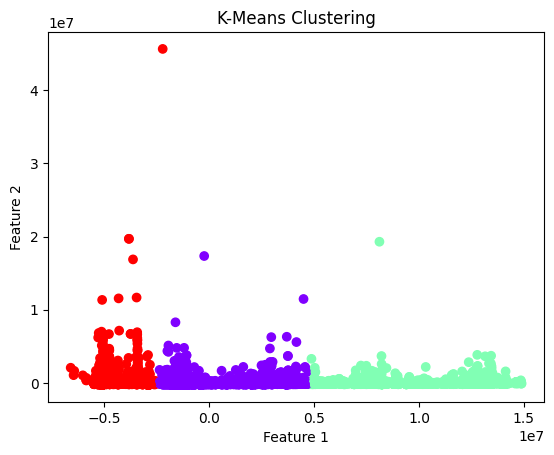

In [56]:
# Create a scatter plot to visualize the clusters
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cluster_assignments, cmap='rainbow')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.show()